In [70]:
# importing necessary libraries
import pandas as pd
import numpy as np
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pylab as plt
import yfinance
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model

import sklearn as sk
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cluster import KMeans

import statsmodels.api as sm

import testing
import boxcox

## 1. Data cleaning

<i> Asset data <i/>

In [71]:
# downloaded the data, calculated returns and converted date into pandas date format 

bond = pd.read_csv('bond.csv',parse_dates=True)
# bond returns are calculated in the excel file itself (summation of price change and interest)
bond['date'] = pd.to_datetime(bond.date) 

equity = pd.read_csv('equity.csv',parse_dates=True)
equity['equity_ret'] = equity.adj_close.pct_change()
equity['date']= pd.to_datetime(equity.date)

forex = pd.read_csv('forex.csv',parse_dates=True)
forex['forex_ret'] = forex.adj_close.pct_change()
forex['date'] = pd.to_datetime(forex.date)

gc = pd.read_csv('gc.csv',parse_dates=True)
gc['gc_ret'] = gc.adj_close.pct_change()
gc['date'] = pd.to_datetime(gc.date)

In [72]:
# Combined return data

combined = pd.concat([bond.set_index('date'),equity.set_index('date'),forex.set_index('date'),\
                      gc.set_index('date')],axis=1, join='inner')

returns = combined.loc[:,['bond_ret','equity_ret','forex_ret','gc_ret']]
returns.reset_index(inplace=True)

returns['year'] = returns['date'].dt.year
returns['month'] = returns['date'].dt.month
returns['quarter'] = returns.month.apply(lambda v: 'Q1' if v <=3 else 'Q2' if v<=6 else 'Q3' if v<=9 else 'Q4')
returns['year_quarter'] = returns.year.astype(str) + '-' + returns.quarter.astype(str)

returns.tail()

,date,bond_ret,equity_ret,forex_ret,gc_ret,year,month,quarter,year_quarter
9538,2020-04-24,-0.000022,0.013918,-0.000498,-0.011749,2020,4,Q2,2020-Q2
9539,2020-04-27,0.000010,0.014714,-0.003387,-0.000525,2020,4,Q2,2020-Q2
9540,2020-04-28,0.000028,-0.005242,-0.001699,-0.013644,2020,4,Q2,2020-Q2
9541,2020-04-29,0.000028,0.026584,-0.003004,0.006976,2020,4,Q2,2020-Q2
9542,2020-04-30,0.000028,-0.009212,-0.005524,-0.000352,2020,4,Q2,2020-Q2


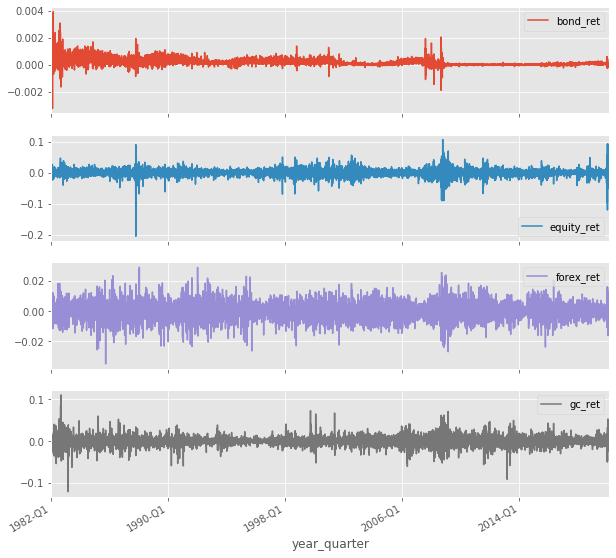

In [73]:
returns.set_index('year_quarter')[['bond_ret','equity_ret','forex_ret','gc_ret']].plot(subplots=True, figsize=(10,10))
pass

<i> Macro-economic factors <i/>

In [74]:
infl = pd.read_csv('inflation.csv')
# inflation already in terms of growth rate
infl['end_date'] = pd.to_datetime(infl.end_date)

gdp = pd.read_csv('gdp.csv')
gdp['gdp_gw_rate'] = gdp.adj_value_gdp.pct_change() 
gdp['end_date'] = pd.to_datetime(gdp.end_date)

unemp = pd.read_csv('unemp.csv')
unemp['unemp_gw_rate'] = unemp.adj_value_unemp.pct_change(3) # converting monthly to quarterly returns
unemp['end_date'] = pd.to_datetime(unemp.end_date)

In [75]:
macroeco = pd.concat([infl.set_index('end_date'),gdp.set_index('end_date'),\
                      unemp.set_index('end_date')],axis=1, join='inner')
macroeco = macroeco.loc[:,['infl_gw_rate','gdp_gw_rate','unemp_gw_rate']]
macroeco.reset_index(inplace=True)
macroeco['month'] = macroeco.end_date.dt.month
macroeco['year'] = macroeco.end_date.dt.year
macroeco['quarter'] = macroeco.month.apply(lambda v: 'Q1' if v==3 else 'Q2' if v==6 else 'Q3' if v==9 else 'Q4')
macroeco['year_quart'] = macroeco.year.astype(str) + '-' + macroeco.quarter.astype(str)

In [76]:
macroeco.head()

,end_date,infl_gw_rate,gdp_gw_rate,unemp_gw_rate,month,year,quarter,year_quart
0,1960-03-31,-0.113379,0.026576,0.019984,3,1960,Q1,1960-Q1
1,1960-06-30,0.567537,-0.002890,0.010735,6,1960,Q2,1960-Q2
2,1960-09-30,0.225734,0.008361,0.031333,9,1960,Q3,1960-Q3
3,1960-12-31,0.675676,-0.009910,0.188723,12,1960,Q4,1960-Q4
4,1961-03-31,0.000000,0.008925,0.051115,3,1961,Q1,1961-Q1


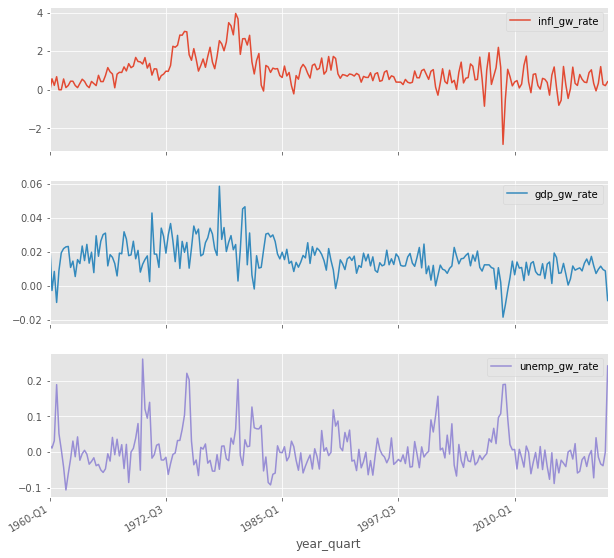

In [77]:
macroeco.set_index('year_quart')[['infl_gw_rate','gdp_gw_rate','unemp_gw_rate']].plot(subplots=True, figsize=(10,10))
pass

## 3. Quarterly correlation matrix

In [78]:
# creating a dictionary with keys as the quarter and values as correlation between assets for that quarter
CORR_YQ = {}
COV_YQ = {}
for year in range(1982, 2021):
    for quarter in range(1,5):
        sub3 = returns[(returns['year'] == year) & (returns['quarter'] == ('Q'+str(quarter)))]
        CORR_YQ[str(year)+'-'+'Q'+str(quarter)] = sub3[['equity_ret','bond_ret','forex_ret', 'gc_ret']].corr()
        COV_YQ[str(year)+'-'+'Q'+str(quarter)] = sub3[['equity_ret','bond_ret','forex_ret', 'gc_ret']].cov()

# Creating a list with quarter names and relevant correlation values
Xq = []
Yq = []

for year_quarter in sorted(CORR_YQ.keys()):
    corr_ravelled = np.ravel(CORR_YQ[year_quarter])
    Xq += [year_quarter]
    Yq += [corr_ravelled[[(1,2,3,6,7,11)]]]        
             
# Creating a dataframe with quarter lables and relevant correlation values
pairs_q = {1:('Bond','SP500'),2:('Forex','SP500'),3:('Gold','SP500'),
         6: ('Forex','Bond'),7: ('Gold','Bond'),11: ('Gold','Forex')}

report_q = []

for year_quarter in sorted(CORR_YQ.keys()):
    corr_q = np.ravel(CORR_YQ[year_quarter])
    
    for i in (1,2,3,6,7,11):
        r = {'year_quarter': year_quarter,
             'symbol_1': pairs_q[i][0],
             'symbol_2': pairs_q[i][1],
             'corr_coeff': corr_q[i]}
        report_q += [r]

df_corr_quarter = pd.DataFrame(report_q)

# Dataframe with combination value 
df_corr_quarter['combination'] = df_corr_quarter.symbol_1 + " & " + df_corr_quarter.symbol_2
data_q = pd.DataFrame(columns= df_corr_quarter.combination.unique(),index = df_corr_quarter.year_quarter.unique(),data = Yq)
data_qt = data_q.transpose()
data_qt = data_qt.iloc[:,:-2]

In [79]:
fig = go.Figure(data=go.Heatmap(z=data_qt,x=data_qt.columns.unique(),y=df_corr_quarter.combination.unique(),colorscale=['red','green']))
fig.update_layout(
    title='Correlation between assets from 1982-Q1 to 2020-Q1',
    xaxis_nticks=50)
fig.show()

## 4. Combining assets and macro-economic factors

In [80]:
combined_df = pd.concat([macroeco.set_index('year_quart'),data_q],axis=1, join='inner')
combinedall = combined_df.loc[:,['infl_gw_rate','gdp_gw_rate','unemp_gw_rate','Bond & SP500', 'Forex & SP500', 'Gold & SP500',
       'Forex & Bond', 'Gold & Bond', 'Gold & Forex']]
combinedall['regimes'] = combinedall.apply(lambda m: \
                        '+GDP+Infl+Unemp' if ((m.gdp_gw_rate>=0)&(m.infl_gw_rate>=0)&(m.unemp_gw_rate>=0)) else
                        '+GDP+Infl-Unemp' if ((m.gdp_gw_rate>=0)&(m.infl_gw_rate>=0)&(m.unemp_gw_rate<0)) else
                        '+GDP-Infl+Unemp' if ((m.gdp_gw_rate>=0)&(m.infl_gw_rate<0)&(m.unemp_gw_rate>=0)) else
                        '+GDP-Infl-Unemp' if ((m.gdp_gw_rate>=0)&(m.infl_gw_rate<0)&(m.unemp_gw_rate<0)) else
                        '-GDP+Infl+Unemp' if ((m.gdp_gw_rate<0)&(m.infl_gw_rate>=0)&(m.unemp_gw_rate>=0)) else
                        '-GDP+Infl-Unemp' if ((m.gdp_gw_rate<0)&(m.infl_gw_rate>=0)&(m.unemp_gw_rate<0)) else
                        '-GDP-Infl+Unemp' if ((m.gdp_gw_rate<0)&(m.infl_gw_rate<0)&(m.unemp_gw_rate>=0)) else
                        '-GDP-Infl-Unemp' if ((m.gdp_gw_rate<0)&(m.infl_gw_rate<0)&(m.unemp_gw_rate<0)) else 'NA', axis=1)
combinedall.regimes.value_counts(dropna = False)

+GDP+Infl-Unemp    85
+GDP+Infl+Unemp    50
+GDP-Infl-Unemp     6
-GDP+Infl+Unemp     6
+GDP-Infl+Unemp     4
-GDP-Infl+Unemp     2
Name: regimes, dtype: int64

-GDP+Infl-Unemp and -GDP-Infl-Unemp not observed. We have considered percentage change in unemployment. Hence this means when GDP goes down, unemployment always goes up, atleast for the period under consideration.

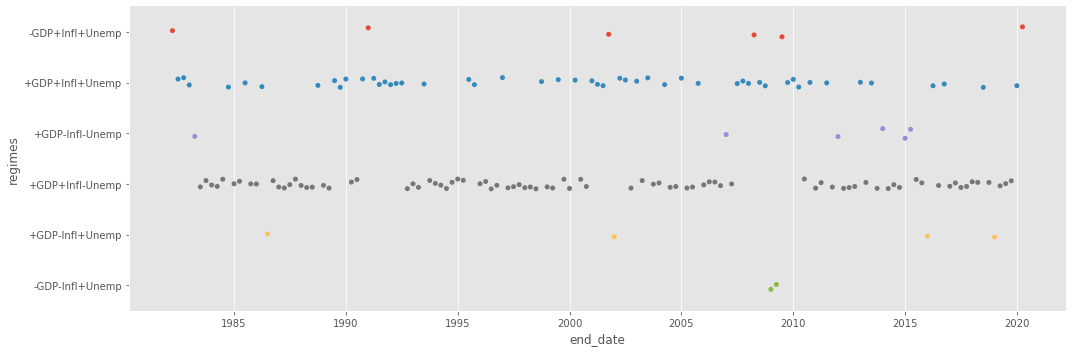

In [81]:
pl = pd.DataFrame(combined_df['end_date'])
pl['regimes'] = combinedall.regimes
sns.catplot(data=pl,x='end_date',y='regimes', aspect=3)

### +GDP+Infl-Unemp

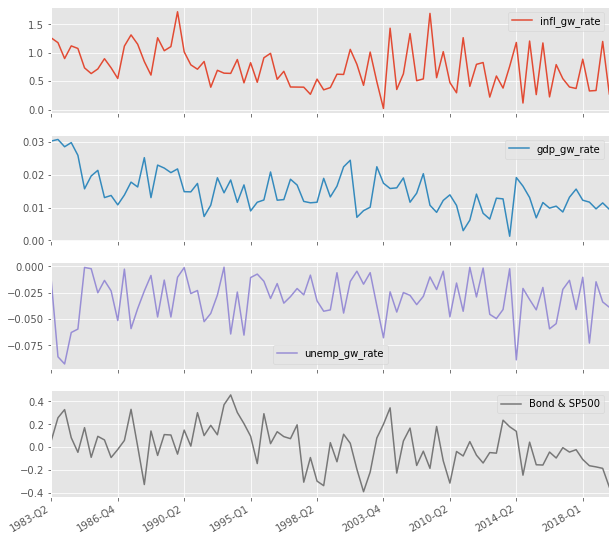

In [82]:
combinedall[combinedall.regimes=='+GDP+Infl-Unemp'].iloc[:,:4].plot(figsize=(10,10), subplots=True)
pass

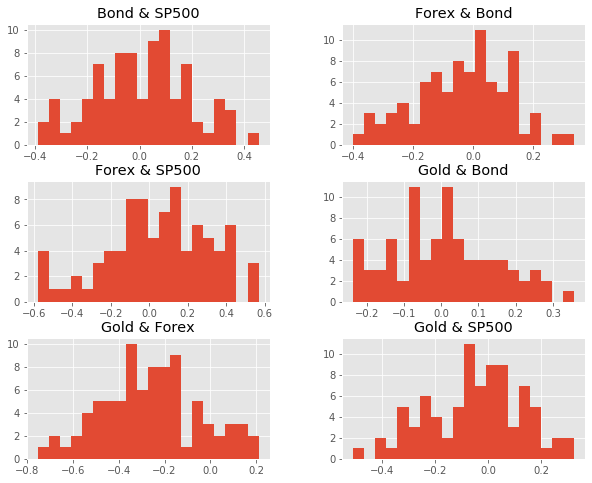

In [83]:
combinedall[combinedall.regimes=='+GDP+Infl-Unemp'].iloc[:,3:].hist(bins=20,figsize=(10,8))
pass

In [84]:
combinedall[combinedall.regimes=='+GDP+Infl-Unemp'].iloc[:,3:-1].aggregate([min,np.mean,np.std,np.median,max]).round(2)

,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex
min,-0.39,-0.58,-0.51,-0.40,-0.24,-0.75
mean,0.01,0.05,-0.05,-0.04,0.01,-0.26
std,0.18,0.27,0.18,0.16,0.14,0.22
median,0.01,0.07,-0.02,-0.02,0.00,-0.25
max,0.46,0.57,0.32,0.33,0.36,0.21


In [85]:
combinedall[combinedall.regimes=='+GDP+Infl-Unemp'].describe()

,infl_gw_rate,gdp_gw_rate,unemp_gw_rate,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,0.735959,0.014926,-0.030409,0.008727,0.047993,-0.048290,-0.039214,0.006293,-0.259847
std,0.362461,0.005991,0.021691,0.184560,0.269381,0.177897,0.155037,0.138111,0.216250
min,0.018060,0.001254,-0.092492,-0.389192,-0.577927,-0.506962,-0.400413,-0.235639,-0.753803
25%,0.426321,0.011443,-0.043326,-0.119895,-0.099443,-0.177398,-0.142035,-0.083620,-0.392781
50%,0.690767,0.013713,-0.027043,0.008825,0.073700,-0.023860,-0.024204,0.002414,-0.251188
75%,1.015361,0.018675,-0.013337,0.134587,0.252380,0.068268,0.056092,0.107888,-0.146042
max,1.721398,0.030829,-0.000826,0.456057,0.568210,0.323169,0.334762,0.356221,0.211233


### +GDP+Infl+Unemp

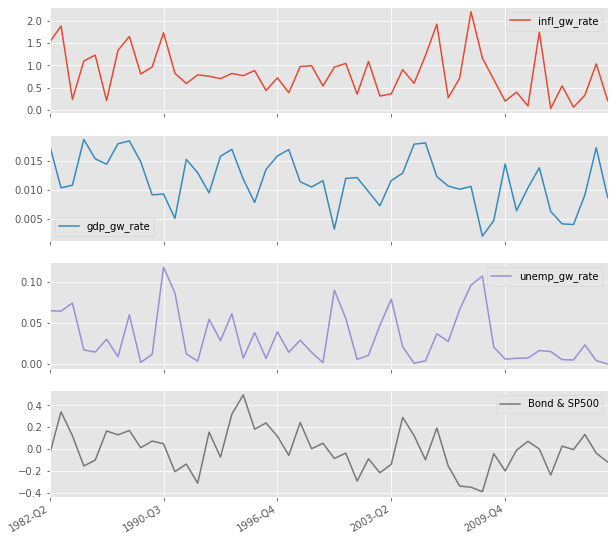

In [86]:
combinedall[combinedall.regimes=='+GDP+Infl+Unemp'].iloc[:,:4].plot(figsize=(10,10), subplots=True)
pass

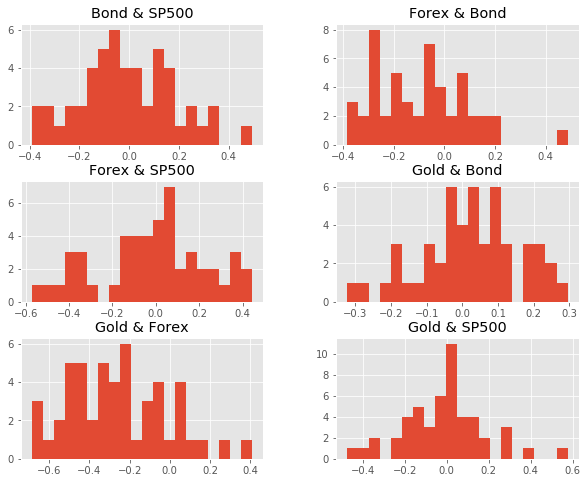

In [87]:
combinedall[combinedall.regimes=='+GDP+Infl+Unemp'].iloc[:,3:].hist(bins=20,figsize=(10,8))
pass

In [88]:
combinedall[combinedall.regimes=='+GDP+Infl+Unemp'].iloc[:,3:-1].aggregate([min,np.mean,np.std,np.median,max]).round(2)

,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex
min,-0.39,-0.57,-0.47,-0.39,-0.32,-0.69
mean,-0.01,-0.01,-0.01,-0.09,0.02,-0.25
std,0.19,0.25,0.20,0.18,0.14,0.25
median,-0.01,-0.01,0.02,-0.08,0.03,-0.27
max,0.49,0.44,0.58,0.49,0.30,0.41


## 5. ACF and PACF plots for different coorelation combinations

In [89]:
combinedall.head()

,infl_gw_rate,gdp_gw_rate,unemp_gw_rate,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex,regimes
1982-Q1,0.818214,-0.001986,0.067767,0.199004,-0.170585,0.383209,-0.329875,0.143122,-0.161102,-GDP+Infl+Unemp
1982-Q2,1.517290,0.017613,0.064982,-0.048714,-0.306788,0.182098,-0.141025,0.105668,-0.207316,+GDP+Infl+Unemp
1982-Q3,1.876955,0.010309,0.064433,0.339797,-0.326359,0.284872,-0.229541,0.064504,-0.436096,+GDP+Infl+Unemp
1982-Q4,0.238826,0.010765,0.074351,0.120391,-0.179832,0.153034,-0.339520,0.209176,-0.485275,+GDP+Infl+Unemp
1983-Q1,-0.068074,0.020823,-0.053357,0.023968,-0.225484,0.203968,-0.124499,-0.047433,-0.395632,+GDP-Infl-Unemp


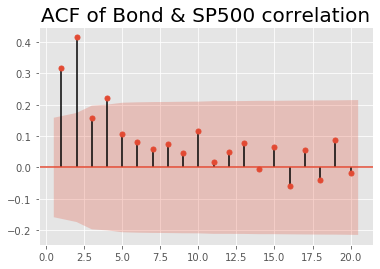

In [90]:
sgt.plot_acf(combinedall['Bond & SP500'], zero = False, lags = 20)
plt.title("ACF of Bond & SP500 correlation",size=20)
plt.show()

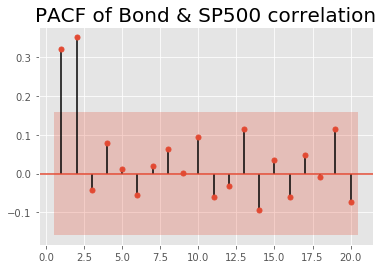

In [91]:
sgt.plot_pacf(combinedall['Bond & SP500'], lags = 20, zero = False, method = ('ols'))
plt.title("PACF of Bond & SP500 correlation", size = 20)
plt.show()

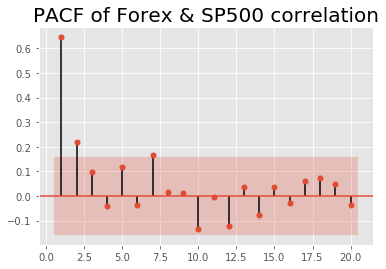

In [92]:
sgt.plot_pacf(combinedall['Forex & SP500'], zero = False, lags = 20, method = ('ols'))
plt.title("PACF of Forex & SP500 correlation",size=20)
plt.show()

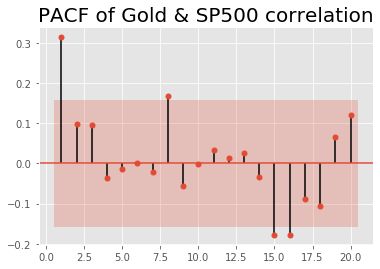

In [93]:
sgt.plot_pacf(combinedall['Gold & SP500'], zero = False, lags = 20, method = ('ols'))
plt.title("PACF of Gold & SP500 correlation",size=20)
plt.show()

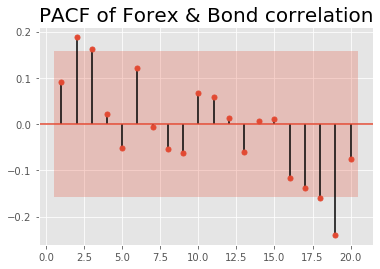

In [94]:
sgt.plot_pacf(combinedall['Forex & Bond'], zero = False, lags = 20, method = ('ols'))
plt.title("PACF of Forex & Bond correlation",size=20)
plt.show()

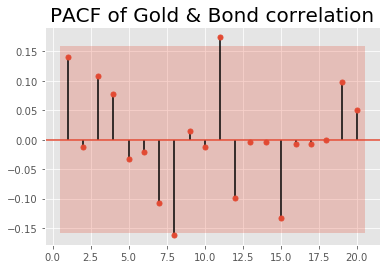

In [95]:
sgt.plot_pacf(combinedall['Gold & Bond'], zero = False, lags = 20, method = ('ols'))
plt.title("PACF of Gold & Bond correlation",size=20)
plt.show()

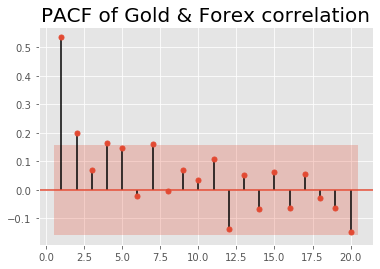

In [96]:
sgt.plot_pacf(combinedall['Gold & Forex'], zero = False, lags = 20, method = ('ols'))
plt.title("PACF of Gold & Forex correlation",size=20)
plt.show()

## 5. ARIMAX model


5.1 Tried adding unemployment rate as the exogenous variable for Bond and SP500 correlation

In [97]:
arimax_model_unemp = ARIMA(combinedall['Bond & SP500'], 
                     exog = combinedall.unemp_gw_rate,
                     order = (2,0,2))
results_arimax_unemp = arimax_model_unemp.fit()
results_arimax_unemp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Bond & SP500   No. Observations:                  153
Model:                     ARMA(2, 2)   Log Likelihood                  59.166
Method:                       css-mle   S.D. of innovations              0.164
Date:                Tue, 21 Jul 2020   AIC                           -104.331
Time:                        08:43:53   BIC                            -83.118
Sample:                    01-01-1982   HQIC                           -95.714
                         - 01-01-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0004      0.031     -0.011      0.991      -0.062       0.061
unemp_gw_rate          0.1782      0.315      0.565      0.572      -0.440       0.797
ar.L1.Bond & SP500     0.0292      0.190      0.154      0.878      -0.343       0.402
ar.L2.Bond & SP500     0.5091      0.180      2.832      0.005       0.157       0.861
ma.L1.Bond & SP500     0.2066      0.211      0.979      0.328      -0.207       0.620
ma.L2.Bond & SP500    -0.1050      0.190     -0.552      0.581      -0.478       0.268
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3731           +0.0000j            1.3731            0.0000
AR.2           -1.4305           +0.0000j            1.4305            0.5000
MA.1           -2.2553           +0.0000j            2.2553            0.5000
MA.2            4.2229           +0.0000j            4.2229            0.0000
-----------------------------------------------------------------------------
"""

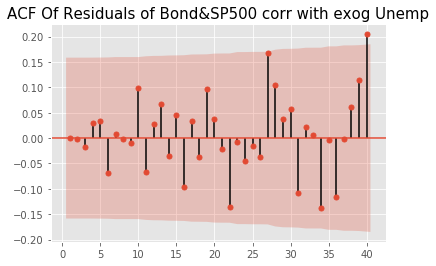

In [98]:
res_arimax_unemp = results_arimax_unemp.resid
sgt.plot_acf(res_arimax_unemp, zero = False, lags = 40)
plt.title("ACF Of Residuals of Bond&SP500 corr with exog Unemp",size=15)
plt.show()

5.2 Tried adding GDP as the exogenous variable for Bond and SP500 correlation

In [99]:
arimax_model_gdp = ARIMA(combinedall['Bond & SP500'], 
                     exog = combinedall.gdp_gw_rate,
                     order = (2,0,2))
results_arimax_gdp = arimax_model_gdp.fit()
results_arimax_gdp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Bond & SP500   No. Observations:                  153
Model:                     ARMA(2, 2)   Log Likelihood                  59.009
Method:                       css-mle   S.D. of innovations              0.164
Date:                Tue, 21 Jul 2020   AIC                           -104.019
Time:                        08:43:53   BIC                            -82.806
Sample:                    01-01-1982   HQIC                           -95.402
                         - 01-01-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0025      0.043      0.059      0.953      -0.082       0.087
gdp_gw_rate           -0.1932      2.519     -0.077      0.939      -5.130       4.744
ar.L1.Bond & SP500     0.0238      0.196      0.121      0.903      -0.360       0.408
ar.L2.Bond & SP500     0.5087      0.186      2.739      0.006       0.145       0.873
ma.L1.Bond & SP500     0.2002      0.216      0.928      0.354      -0.223       0.623
ma.L2.Bond & SP500    -0.1189      0.200     -0.594      0.553      -0.511       0.273
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3789           +0.0000j            1.3789            0.0000
AR.2           -1.4256           +0.0000j            1.4256            0.5000
MA.1           -2.1779           +0.0000j            2.1779            0.5000
MA.2            3.8610           +0.0000j            3.8610            0.0000
-----------------------------------------------------------------------------
"""

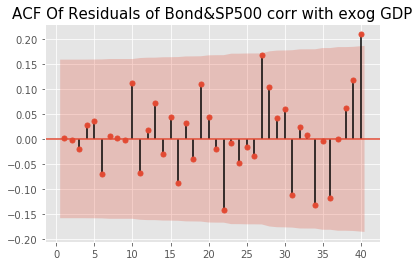

In [100]:
res_arimax_gdp = results_arimax_gdp.resid
sgt.plot_acf(res_arimax_gdp, zero = False, lags = 40)
plt.title("ACF Of Residuals of Bond&SP500 corr with exog GDP",size=15)
plt.show()

5.3 Tried converting regimes into categorical variable and use them as exogenous inputs for Bond and SP500 correlation

In [101]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
df2 = combinedall.copy()
df2['regimes']=lb_make.fit_transform(df2['regimes'])
df2.regimes.value_counts()


1    85
0    50
4     6
3     6
2     4
5     2
Name: regimes, dtype: int64

In [102]:
arimax_regimes = ARIMA(df2['Bond & SP500'], 
                     exog = df2.regimes,
                     order = (2,0,2))
results_arimax_regimes = arimax_regimes.fit()
results_arimax_regimes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Bond & SP500   No. Observations:                  153
Model:                     ARMA(2, 2)   Log Likelihood                  59.007
Method:                       css-mle   S.D. of innovations              0.164
Date:                Tue, 21 Jul 2020   AIC                           -104.014
Time:                        08:43:54   BIC                            -82.801
Sample:                    01-01-1982   HQIC                           -95.397
                         - 01-01-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0002      0.032     -0.005      0.996      -0.064       0.063
regimes                0.0003      0.012      0.028      0.978      -0.023       0.024
ar.L1.Bond & SP500     0.0220      0.196      0.113      0.910      -0.361       0.405
ar.L2.Bond & SP500     0.5098      0.188      2.715      0.007       0.142       0.878
ma.L1.Bond & SP500     0.2000      0.218      0.915      0.360      -0.228       0.628
ma.L2.Bond & SP500    -0.1227      0.199     -0.617      0.537      -0.513       0.267
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3791           +0.0000j            1.3791            0.0000
AR.2           -1.4224           +0.0000j            1.4224            0.5000
MA.1           -2.1538           +0.0000j            2.1538            0.5000
MA.2            3.7831           +0.0000j            3.7831            0.0000
-----------------------------------------------------------------------------
"""

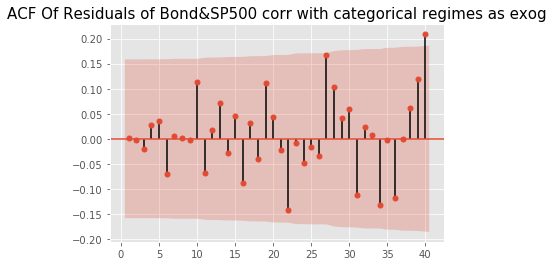

In [103]:
res_arimax_regimes = results_arimax_regimes.resid
sgt.plot_acf(res_arimax_regimes, zero = False, lags = 40)
plt.title("ACF Of Residuals of Bond&SP500 corr with categorical regimes as exog",size=15)
plt.show()

5.4 Tried adding all the macroeconomic factors as exogenous inputs for Bond and SP500 correlation

In [104]:
arimax_model_macroeco = ARIMA(combinedall['Bond & SP500'], 
                     exog = combinedall[['gdp_gw_rate','unemp_gw_rate','infl_gw_rate']],
                     order = (2,0,2))
results_arimax_macroeco = arimax_model_macroeco.fit()
results_arimax_macroeco.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Bond & SP500   No. Observations:                  153
Model:                     ARMA(2, 2)   Log Likelihood                  59.285
Method:                       css-mle   S.D. of innovations              0.164
Date:                Tue, 21 Jul 2020   AIC                           -100.570
Time:                        08:43:55   BIC                            -73.296
Sample:                    01-01-1982   HQIC                           -89.491
                         - 01-01-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0081      0.046     -0.175      0.861      -0.099       0.083
gdp_gw_rate            0.1152      2.987      0.039      0.969      -5.738       5.969
unemp_gw_rate          0.1872      0.356      0.526      0.599      -0.510       0.884
infl_gw_rate           0.0096      0.021      0.448      0.654      -0.032       0.051
ar.L1.Bond & SP500     0.0280      0.195      0.143      0.886      -0.355       0.411
ar.L2.Bond & SP500     0.5066      0.183      2.767      0.006       0.148       0.865
ma.L1.Bond & SP500     0.2051      0.214      0.956      0.339      -0.215       0.625
ma.L2.Bond & SP500    -0.1063      0.195     -0.544      0.586      -0.489       0.277
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3777           +0.0000j            1.3777            0.0000
AR.2           -1.4329           +0.0000j            1.4329            0.5000
MA.1           -2.2508           +0.0000j            2.2508            0.5000
MA.2            4.1805           +0.0000j            4.1805            0.0000
-----------------------------------------------------------------------------
"""

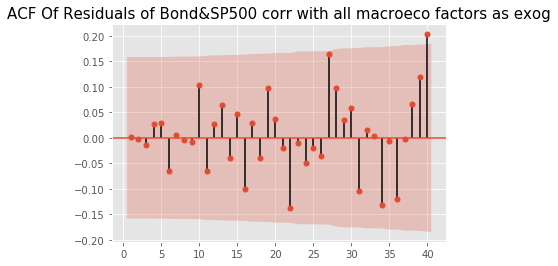

In [105]:
res_arimax_macroeco = results_arimax_macroeco.resid
sgt.plot_acf(res_arimax_macroeco, zero = False, lags = 40)
plt.title("ACF Of Residuals of Bond&SP500 corr with all macroeco factors as exog",size=15)
plt.show()

Testing the results

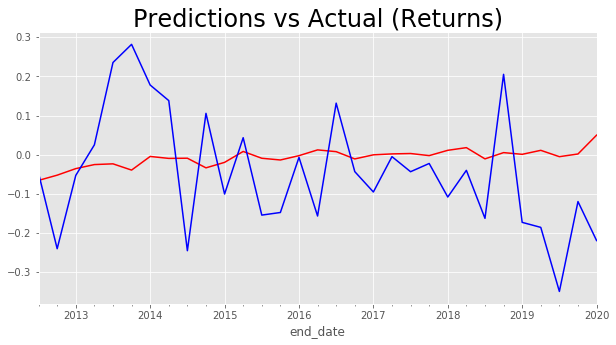

In [106]:
combined_df['regimes'] = combinedall['regimes']
combined_df.set_index('end_date',inplace=True)
combined_df.head()

from sklearn.model_selection import train_test_split
train, test = train_test_split(combined_df, test_size=0.2, shuffle=False)


arimax_macroeco_train = ARIMA(train['Bond & SP500'], 
                     exog = train[['gdp_gw_rate','unemp_gw_rate','infl_gw_rate']],
                     order = (2,0,2))
results_arimax_macroeco_train = arimax_macroeco_train.fit()


start_date = '2012-09-30'
end_date = '2020-03-31'

pred_armax = results_arimax_macroeco_train.predict(start = start_date, end = end_date, 
                                          exog = test[['gdp_gw_rate','unemp_gw_rate','infl_gw_rate']][start_date:end_date]) 

pred_armax[start_date:end_date].plot(figsize = (10,5), color = "red")
test['Bond & SP500'][start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

## 6. GARCH Model

In [107]:
# Calculating quarterly bond return

bond = bond.set_index('date').asfreq('d').fillna(method='ffill')
bond['price'] = 1 - (bond['adj_close']/100*90/360)

bond_qrt_return = bond['price'].resample('Q').ffill().pct_change()
bond_qrt_return = pd.DataFrame(bond_qrt_return)
bond_qrt_return.columns = ['price_return']

bond_df = pd.concat([bond,bond_qrt_return],axis=1,join='inner')
bond_df['int_return'] = bond_df['adj_close'].shift(1)*90/360/100
bond_df['total_qt_return'] = bond_df['price_return']+bond_df['int_return']

In [108]:
# Calculating and collating quarterly returns for all asset classes

start_date = '1982-03-31'
end_date = '2020-03-31'

eq_qrt_ret = equity.set_index('date')['adj_close'].resample('Q').ffill().pct_change()
bond_qrt_ret = bond_df['total_qt_return'][start_date:end_date]
gold_qrt_ret = gc.set_index('date')['adj_close'].resample('Q').ffill().pct_change()
forex_qrt_ret = forex.set_index('date')['adj_close'].resample('Q').ffill().pct_change()

qrt_ret = pd.DataFrame(data = (eq_qrt_ret,bond_qrt_ret,gold_qrt_ret,forex_qrt_ret))
qrt_ret = qrt_ret.transpose()
qrt_ret.columns = ['eq_qrt_ret','bond_qrt_ret','gold_qrt_ret','forex_qrt_ret']

qrt_ret = qrt_ret[start_date:end_date]

In [109]:
macro_and_assets = pd.concat([qrt_ret,combined_df],axis=1,join='inner')
macro_and_assets = macro_and_assets [['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret', 'Bond & SP500',
       'Forex & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Bond',
       'Gold & Forex', 'regimes']]
macro_and_assets.head(2)

,eq_qrt_ret,bond_qrt_ret,gold_qrt_ret,forex_qrt_ret,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex,regimes
1982-03-31,-0.086414,NaN,-0.194969,0.095902,0.199004,-0.170585,0.383209,-0.329875,0.143122,-0.161102,-GDP+Infl+Unemp
1982-06-30,-0.020990,0.036607,-0.007812,0.037566,-0.048714,-0.306788,0.182098,-0.141025,0.105668,-0.207316,+GDP+Infl+Unemp


### 6.1 Bond quarterly return - GARCH Model

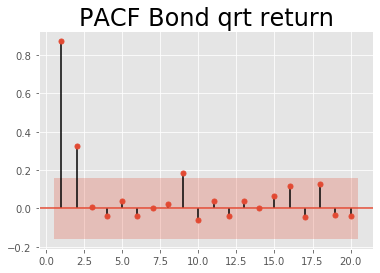

In [110]:
sgt.plot_pacf(macro_and_assets.bond_qrt_ret[1:], lags = 20, zero = False, method = ('ols'))
plt.title("PACF Bond qrt return", size = 24)
plt.show()

In [111]:
garch_bond_2 = arch_model(macro_and_assets.bond_qrt_ret[1:], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_1_1 = garch_bond_2.fit()
results_garch_1_1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: -544.1293515203414
Iteration:      2,   Func. Count:     18,   Neg. LLF: -544.4033934625281
Iteration:      3,   Func. Count:     34,   Neg. LLF: -544.4007703542338
Iteration:      4,   Func. Count:     50,   Neg. LLF: -544.4034111191742
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -544.4034124046586
            Iterations: 8
            Function evaluations: 50
            Gradient evaluations: 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           bond_qrt_ret   R-squared:                      -0.007
Mean Model:             Constant Mean   Adj. R-squared:                 -0.007
Vol Model:                      GARCH   Log-Likelihood:                544.403
Distribution:                  Normal   AIC:                          -1080.81
Method:            Maximum Likelihood   BIC:                          -1068.71
                                        No. Observations:                  152
Date:                Tue, Jul 21 2020   Df Residuals:                      148
Time:                        08:43:56   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0106  9.798e-05    108.333      0.000 [1.042e-02,1.081e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4047e-06  8.680e-11  1.618e+04      0.000 [1.405e-06,1.405e-06]
alpha[1]       0.2000  7.932e-02      2.522  1.168e-02   [4.454e-02,  0.355]
beta[1]        0.7800  5.929e-02     13.156  1.566e-39     [  0.664,  0.896]
============================================================================

Covariance estimator: robust
"""

Testing the model

Iteration:      1,   Func. Count:      6,   Neg. LLF: -443.9875185415079
Iteration:      2,   Func. Count:     19,   Neg. LLF: -443.99463451623984
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -443.99463552438596
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2


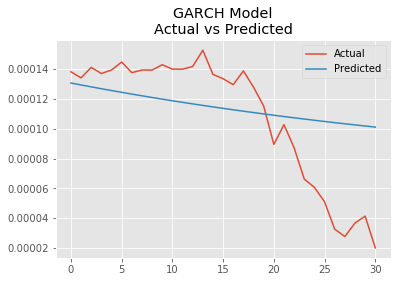

In [112]:
train_garch, test_garch = train_test_split(macro_and_assets.bond_qrt_ret, test_size=0.2, shuffle=False)

garch_1_1_train = arch_model(train_garch[1:], mean = "Constant", vol = "GARCH", p = 1, q = 1)
results_garch_1_1_train = garch_1_1_train.fit()

fc_garch = results_garch_1_1_train.forecast(horizon=31)
pred_y = fc_garch.variance.values[-1,:]
actual_y = (test_garch-np.mean(train_garch))**2


plt.plot(actual_y.tolist(), label='Actual')
plt.plot(pred_y, label='Predicted')
plt.legend()
plt.title('GARCH Model\nActual vs Predicted')
plt.show()

### 6.2 Equity quarterly return - GARCH model

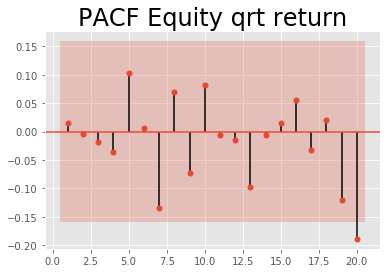

In [113]:
sgt.plot_pacf(macro_and_assets.eq_qrt_ret[1:], lags = 20, zero = False, method = ('ols'))
plt.title("PACF Equity qrt return", size = 24)
plt.show()

### 6.3 Forex quarterly return - GARCH model

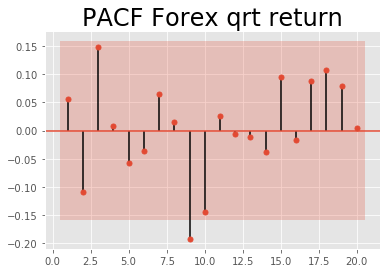

In [114]:
sgt.plot_pacf(macro_and_assets.forex_qrt_ret[1:], lags = 20, zero = False, method = ('ols'))
plt.title("PACF Forex qrt return", size = 24)
plt.show()

### 6.4 Gold quarterly return - GARCH model

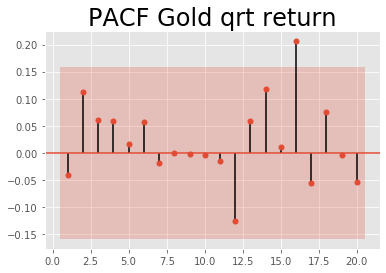

In [115]:
sgt.plot_pacf(macro_and_assets.gold_qrt_ret[1:], lags = 20, zero = False, method = ('ols'))
plt.title("PACF Gold qrt return", size = 24)
plt.show()

## 7. Linear Regression

### 7.1 Bond and SP500

ADF Statistic: -4.827962
p-value: 0.000048
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577

We reject the Null Hypothesis (H0) -- the time series is stationary


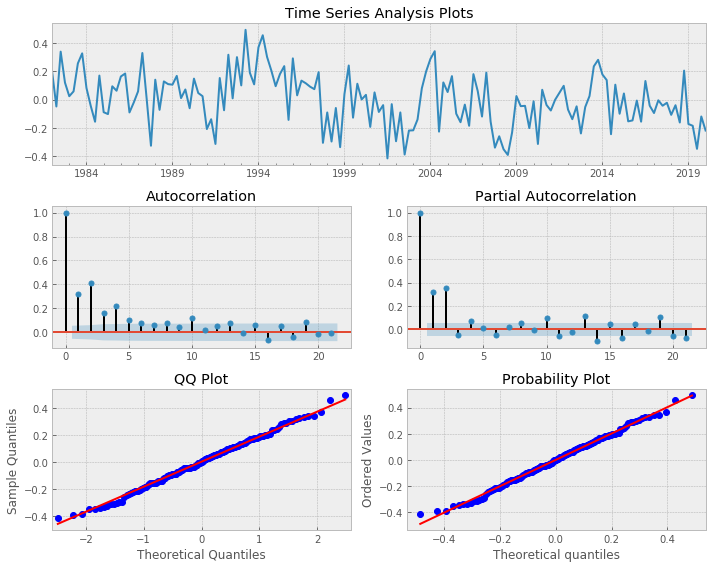

In [116]:
testing.ts_plot(macro_and_assets['Bond & SP500'],lags=21)

In [117]:
# creating dummies for regimes
combined_dummy = macro_and_assets.copy()
combined_dummy['+GDP+Infl-Unemp'] = (combined_dummy['regimes'] == '+GDP+Infl-Unemp')*1
combined_dummy['+GDP+Infl+Unemp'] = (combined_dummy['regimes'] == '+GDP+Infl+Unemp')*1

combined_dummy.drop(columns=['regimes'],inplace=True)


reg1_df = combined_dummy.copy()

# creating lag 1 for returns
reg1_df['eq_qrt_ret'] = reg1_df['eq_qrt_ret'].shift(1)
reg1_df['bond_qrt_ret'] = reg1_df['bond_qrt_ret'].shift(1)
reg1_df['gold_qrt_ret'] = reg1_df['gold_qrt_ret'].shift(1)
reg1_df['forex_qrt_ret'] = reg1_df['forex_qrt_ret'].shift(1)


# creating lag 2 for correlation combinations
reg1_df['Bond & SP500_lag'] = reg1_df['Bond & SP500'].shift(2)
reg1_df['Forex & SP500'] = reg1_df['Forex & SP500'].shift(2)
reg1_df['Gold & SP500'] = reg1_df['Gold & SP500'].shift(2)
reg1_df['Forex & Bond'] = reg1_df['Forex & Bond'].shift(2)
reg1_df['Gold & Bond'] = reg1_df['Gold & Bond'].shift(2)
reg1_df['Gold & Forex'] = reg1_df['Gold & Forex'].shift(2)


reg1_df = reg1_df.dropna()

In [118]:
reg1_df['constant'] = 1

Y = reg1_df['Bond & SP500'].values
X = reg1_df [['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret',
       'Forex & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Bond', 'Gold & Forex', 'Bond & SP500_lag',
              '+GDP+Infl-Unemp','+GDP+Infl+Unemp','constant']]
import statsmodels.api as sm
model = sm.OLS(Y, X)
results = model.fit()
reg1_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     4.430
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           5.60e-06
Time:                        08:43:58   Log-Likelihood:                 63.984
No. Observations:                 151   AIC:                            -102.0
Df Residuals:                     138   BIC:                            -62.74
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
eq_qrt_ret           0.0686      0.183      0.375      0.708      -0.293       0.431
bond_qrt_ret         0.7908      1.678      0.471      0.638      -2.526       4.108
gold_qrt_ret        -0.3505      0.215     -1.628      0.106      -0.776       0.075
forex_qrt_ret       -0.1694      0.333     -0.509      0.612      -0.828       0.489
Forex & SP500        0.0993      0.059      1.693      0.093      -0.017       0.215
Gold & SP500         0.2816      0.087      3.232      0.002       0.109       0.454
Forex & Bond        -0.1453      0.089     -1.633      0.105      -0.321       0.031
Gold & Bond          0.0909      0.112      0.812      0.418      -0.131       0.312
Gold & Forex         0.1449      0.064      2.280      0.024       0.019       0.271
Bond & SP500_lag     0.4058      0.078      5.218      0.000       0.252       0.560
+GDP+Infl-Unemp     -0.0318      0.047     -0.685      0.495      -0.124       0.060
+GDP+Infl+Unemp     -0.0229      0.048     -0.474      0.636      -0.118       0.073
constant             0.0536      0.048      1.109      0.269      -0.042       0.149
==============================================================================
Omnibus:                        0.421   Durbin-Watson:                   1.669
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.568
Skew:                          -0.095   Prob(JB):                        0.753
Kurtosis:                       2.767   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [119]:
fig = px.scatter(x=reg1_fittedvalues,y=Y)
fig.show()

In [120]:
reg2_df = reg1_df.copy()
Y = reg2_df['Bond & SP500'].values
X = reg2_df [['gold_qrt_ret', 
       'Forex & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Forex', 'Bond & SP500_lag',
             'constant']]

model = sm.OLS(Y, X)
results = model.fit()
reg2_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     8.820
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           3.43e-08
Time:                        08:43:58   Log-Likelihood:                 63.011
No. Observations:                 151   AIC:                            -112.0
Df Residuals:                     144   BIC:                            -90.90
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
gold_qrt_ret        -0.3044      0.192     -1.582      0.116      -0.685       0.076
Forex & SP500        0.0932      0.056      1.659      0.099      -0.018       0.204
Gold & SP500         0.2703      0.084      3.237      0.002       0.105       0.435
Forex & Bond        -0.1737      0.083     -2.082      0.039      -0.339      -0.009
Gold & Forex         0.1439      0.061      2.343      0.021       0.022       0.265
Bond & SP500_lag     0.3891      0.072      5.377      0.000       0.246       0.532
constant             0.0362      0.021      1.713      0.089      -0.006       0.078
==============================================================================
Omnibus:                        0.705   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.703   Jarque-Bera (JB):                0.808
Skew:                          -0.069   Prob(JB):                        0.668
Kurtosis:                       2.670   Cond. No.                         15.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
fig = px.scatter(x=reg2_fittedvalues,y=Y)
fig.show()

In [122]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = sm.OLS(y_train, x_train)
results = model.fit()

fig = px.scatter(x=results.fittedvalues,y=y_train)
fig.show()

In [123]:
y_hat = results.predict(x_test)

fig = px.scatter(x=y_hat,y=y_test)
fig.show()

In [124]:
# Mean squared error
((y_test-y_hat)**2).mean()

0.017706266455317907

### 7.2 Forex and S&P

ADF Statistic: -4.169703
p-value: 0.000741
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577

We reject the Null Hypothesis (H0) -- the time series is stationary


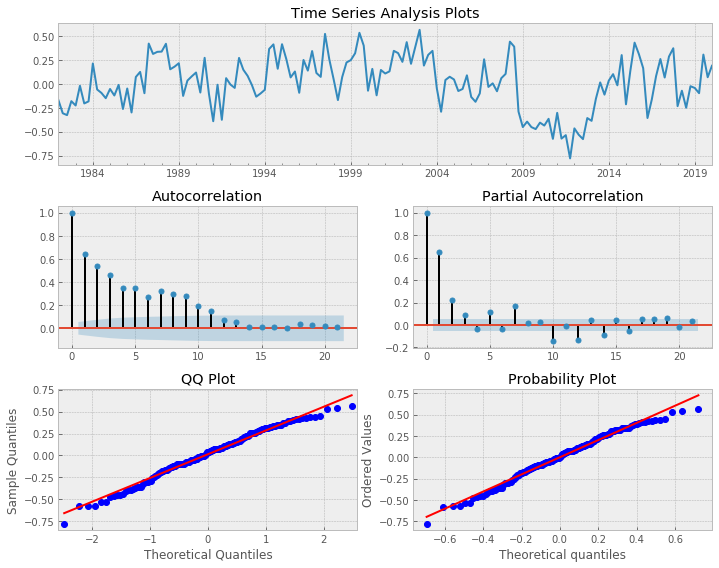

In [125]:
testing.ts_plot(macro_and_assets['Forex & SP500'],lags=21)

In [126]:
reg1_df2 = combined_dummy.copy()

# creating lag 1 for returns
reg1_df2['eq_qrt_ret'] = reg1_df2['eq_qrt_ret'].shift(1)
reg1_df2['bond_qrt_ret'] = reg1_df2['bond_qrt_ret'].shift(1)
reg1_df2['gold_qrt_ret'] = reg1_df2['gold_qrt_ret'].shift(1)
reg1_df2['forex_qrt_ret'] = reg1_df2['forex_qrt_ret'].shift(1)


# creating lag 2 for correlation combinations
reg1_df2['Forex & SP500_lag'] = reg1_df2['Forex & SP500'].shift(2)
reg1_df2['Bond & SP500'] = reg1_df2['Bond & SP500'].shift(2)
reg1_df2['Gold & SP500'] = reg1_df2['Gold & SP500'].shift(2)
reg1_df2['Forex & Bond'] = reg1_df2['Forex & Bond'].shift(2)
reg1_df2['Gold & Bond'] = reg1_df2['Gold & Bond'].shift(2)
reg1_df2['Gold & Forex'] = reg1_df2['Gold & Forex'].shift(2)


reg1_df2 = reg1_df2.dropna()
reg1_df2['constant'] = 1

Y = reg1_df2['Forex & SP500'].values
X = reg1_df2 [['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret',
       'Bond & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Bond', 'Gold & Forex', 'Forex & SP500_lag',
              '+GDP+Infl-Unemp','+GDP+Infl+Unemp','constant']]
import statsmodels.api as sm
model = sm.OLS(Y, X)
results = model.fit()
reg1_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     6.737
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           1.91e-09
Time:                        08:44:01   Log-Likelihood:                 17.914
No. Observations:                 151   AIC:                            -9.827
Df Residuals:                     138   BIC:                             29.40
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
eq_qrt_ret           -0.1549      0.248     -0.624      0.534      -0.646       0.336
bond_qrt_ret          2.2977      2.276      1.010      0.314      -2.203       6.798
gold_qrt_ret         -0.2820      0.292     -0.965      0.336      -0.860       0.296
forex_qrt_ret        -1.0474      0.452     -2.319      0.022      -1.940      -0.154
Bond & SP500          0.0736      0.106      0.697      0.487      -0.135       0.282
Gold & SP500         -0.1031      0.118     -0.872      0.385      -0.337       0.131
Forex & Bond         -0.1163      0.121     -0.963      0.337      -0.355       0.122
Gold & Bond           0.1981      0.152      1.303      0.195      -0.103       0.499
Gold & Forex          0.0396      0.086      0.460      0.647      -0.131       0.210
Forex & SP500_lag     0.4956      0.080      6.231      0.000       0.338       0.653
+GDP+Infl-Unemp       0.0795      0.063      1.260      0.210      -0.045       0.204
+GDP+Infl+Unemp       0.0112      0.066      0.170      0.865      -0.118       0.141
constant             -0.0549      0.066     -0.838      0.403      -0.185       0.075
==============================================================================
Omnibus:                        1.458   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.358
Skew:                          -0.231   Prob(JB):                        0.507
Kurtosis:                       2.956   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
fig = px.scatter(x=reg1_fittedvalues,y=Y)
fig.show()

In [128]:
Y = reg1_df2['Forex & SP500'].values
X = reg1_df2 [['forex_qrt_ret', 'Forex & SP500_lag','constant']]

model = sm.OLS(Y, X)
results = model.fit()
reg2_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     35.06
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           3.44e-13
Time:                        08:44:01   Log-Likelihood:                 12.380
No. Observations:                 151   AIC:                            -18.76
Df Residuals:                     148   BIC:                            -9.709
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
forex_qrt_ret        -0.9741      0.408     -2.386      0.018      -1.781      -0.167
Forex & SP500_lag     0.5540      0.068      8.193      0.000       0.420       0.688
constant              0.0102      0.018      0.559      0.577      -0.026       0.046
==============================================================================
Omnibus:                        1.971   Durbin-Watson:                   1.386
Prob(Omnibus):                  0.373   Jarque-Bera (JB):                1.665
Skew:                          -0.253   Prob(JB):                        0.435
Kurtosis:                       3.094   Cond. No.                         22.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [129]:
fig = px.scatter(x=reg2_fittedvalues,y=Y)
fig.show()

In [130]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = sm.OLS(y_train, x_train)
results = model.fit()

fig = px.scatter(x=results.fittedvalues,y=y_train)
fig.show()

In [131]:
y_hat = results.predict(x_test)

fig = px.scatter(x=y_hat,y=y_test)
fig.show()

### 7.3 Gold & SP500

ADF Statistic: -8.735530
p-value: 0.000000
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577

We reject the Null Hypothesis (H0) -- the time series is stationary


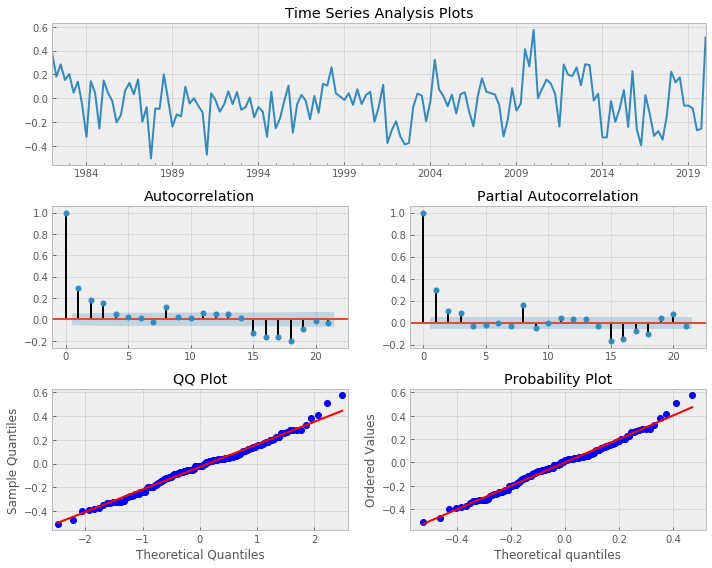

In [132]:
testing.ts_plot(macro_and_assets['Gold & SP500'],lags=21)

In [133]:
reg1_df3 = combined_dummy.copy()

# creating lag 1 for returns
reg1_df3['eq_qrt_ret'] = reg1_df3['eq_qrt_ret'].shift(1)
reg1_df3['bond_qrt_ret'] = reg1_df3['bond_qrt_ret'].shift(1)
reg1_df3['gold_qrt_ret'] = reg1_df3['gold_qrt_ret'].shift(1)
reg1_df3['forex_qrt_ret'] = reg1_df3['forex_qrt_ret'].shift(1)


# creating lag 2 for correlation combinations
reg1_df3['Gold & SP500_lag'] = reg1_df3['Gold & SP500'].shift(2)
reg1_df3['Bond & SP500'] = reg1_df3['Bond & SP500'].shift(2)
reg1_df3['Forex & SP500'] = reg1_df3['Forex & SP500'].shift(2)
reg1_df3['Forex & Bond'] = reg1_df3['Forex & Bond'].shift(2)
reg1_df3['Gold & Bond'] = reg1_df3['Gold & Bond'].shift(2)
reg1_df3['Gold & Forex'] = reg1_df3['Gold & Forex'].shift(2)


reg1_df3 = reg1_df3.dropna()
reg1_df3['constant'] = 1

Y = reg1_df3['Gold & SP500'].values
X = reg1_df3[['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret',
       'Bond & SP500', 'Forex & SP500', 'Forex & Bond', 'Gold & Bond', 'Gold & Forex', 'Gold & SP500_lag',
              '+GDP+Infl-Unemp','+GDP+Infl+Unemp','constant']]
import statsmodels.api as sm
model = sm.OLS(Y, X)
results = model.fit()
reg1_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     2.342
Date:                Tue, 21 Jul 2020   Prob (F-statistic):            0.00917
Time:                        08:44:04   Log-Likelihood:                 52.622
No. Observations:                 151   AIC:                            -79.24
Df Residuals:                     138   BIC:                            -40.02
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
eq_qrt_ret           0.3718      0.197      1.884      0.062      -0.018       0.762
bond_qrt_ret         0.3432      1.809      0.190      0.850      -3.233       3.919
gold_qrt_ret         0.0194      0.232      0.084      0.933      -0.439       0.478
forex_qrt_ret        0.5842      0.359      1.628      0.106      -0.125       1.294
Bond & SP500        -0.0405      0.084     -0.483      0.630      -0.206       0.125
Forex & SP500       -0.1907      0.063     -3.017      0.003      -0.316      -0.066
Forex & Bond         0.0764      0.096      0.796      0.427      -0.113       0.266
Gold & Bond         -0.1058      0.121     -0.876      0.383      -0.345       0.133
Gold & Forex         0.0541      0.069      0.789      0.431      -0.081       0.190
Gold & SP500_lag     0.0688      0.094      0.732      0.465      -0.117       0.255
+GDP+Infl-Unemp     -0.0654      0.050     -1.304      0.194      -0.165       0.034
+GDP+Infl+Unemp     -0.0275      0.052     -0.528      0.598      -0.131       0.075
constant             0.0266      0.052      0.510      0.611      -0.076       0.130
==============================================================================
Omnibus:                        3.534   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.171   Jarque-Bera (JB):                3.150
Skew:                           0.248   Prob(JB):                        0.207
Kurtosis:                       3.505   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
fig = px.scatter(x=reg1_fittedvalues,y=Y)
fig.show()

In [135]:
Y = reg1_df3['Gold & SP500'].values
X = reg1_df3[['eq_qrt_ret','forex_qrt_ret', 'Forex & SP500','constant']]

model = sm.OLS(Y, X)
results = model.fit()
reg2_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                     7.562
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           9.72e-05
Time:                        08:44:04   Log-Likelihood:                 49.465
No. Observations:                 151   AIC:                            -90.93
Df Residuals:                     147   BIC:                            -78.86
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
eq_qrt_ret        0.3100      0.186      1.663      0.099      -0.058       0.679
forex_qrt_ret     0.6169      0.321      1.925      0.056      -0.016       1.250
Forex & SP500    -0.2161      0.053     -4.063      0.000      -0.321      -0.111
constant         -0.0357      0.015     -2.350      0.020      -0.066      -0.006
==============================================================================
Omnibus:                        2.586   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.274   Jarque-Bera (JB):                2.205
Skew:                           0.175   Prob(JB):                        0.332
Kurtosis:                       3.477   Cond. No.                         22.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [136]:
fig = px.scatter(x=reg2_fittedvalues,y=Y)
fig.show()

In [137]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = sm.OLS(y_train, x_train)
results = model.fit()

fig = px.scatter(x=results.fittedvalues,y=y_train)
fig.show()

In [138]:
y_hat = results.predict(x_test)

fig = px.scatter(x=y_hat,y=y_test)
fig.show()

### 7.4 Forex and Bond

ADF Statistic: -4.980823
p-value: 0.000024
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577

We reject the Null Hypothesis (H0) -- the time series is stationary


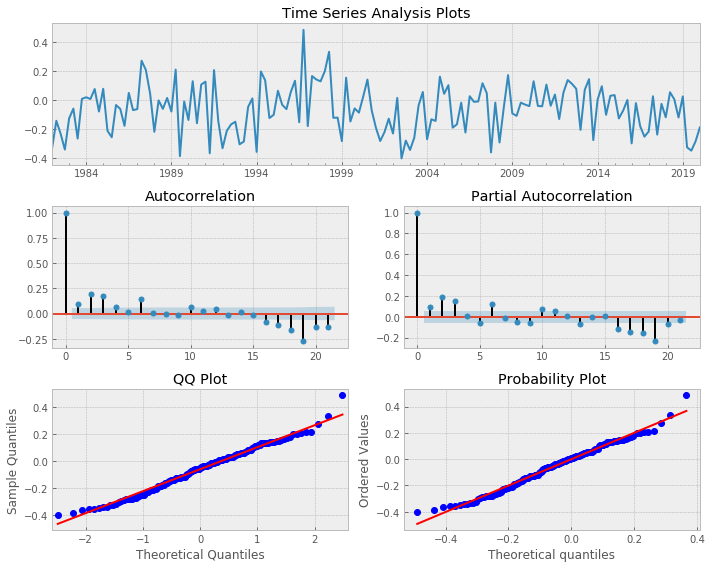

In [139]:
testing.ts_plot(macro_and_assets['Forex & Bond'],lags=21)

In [140]:
reg1_df4 = combined_dummy.copy()

# creating lag 1 for returns
reg1_df4['eq_qrt_ret'] = reg1_df4['eq_qrt_ret'].shift(1)
reg1_df4['bond_qrt_ret'] = reg1_df4['bond_qrt_ret'].shift(1)
reg1_df4['gold_qrt_ret'] = reg1_df4['gold_qrt_ret'].shift(1)
reg1_df4['forex_qrt_ret'] = reg1_df4['forex_qrt_ret'].shift(1)


# creating lag 2 for correlation combinations
reg1_df4['Forex & Bond_lag'] = reg1_df4['Forex & Bond'].shift(1)
reg1_df4['Bond & SP500'] = reg1_df4['Bond & SP500'].shift(1)
reg1_df4['Forex & SP500'] = reg1_df4['Forex & SP500'].shift(1)
reg1_df4['Gold & SP500'] = reg1_df4['Gold & SP500'].shift(1)
reg1_df4['Gold & Bond'] = reg1_df4['Gold & Bond'].shift(1)
reg1_df4['Gold & Forex'] = reg1_df4['Gold & Forex'].shift(1)


reg1_df4 = reg1_df4.dropna()
reg1_df4['constant'] = 1

Y = reg1_df4['Forex & Bond'].values
X = reg1_df4[['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret',
       'Bond & SP500', 'Forex & SP500', 'Gold & SP500', 'Gold & Bond', 'Gold & Forex', 'Forex & Bond_lag',
              '+GDP+Infl-Unemp','+GDP+Infl+Unemp','constant']]
import statsmodels.api as sm
model = sm.OLS(Y, X)
results = model.fit()
reg1_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.363
Date:                Tue, 21 Jul 2020   Prob (F-statistic):              0.191
Time:                        08:44:06   Log-Likelihood:                 68.270
No. Observations:                 151   AIC:                            -110.5
Df Residuals:                     138   BIC:                            -71.32
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
eq_qrt_ret          -0.0681      0.184     -0.371      0.711      -0.431       0.295
bond_qrt_ret        -1.0821      1.632     -0.663      0.508      -4.309       2.145
gold_qrt_ret        -0.2336      0.207     -1.127      0.261      -0.643       0.176
forex_qrt_ret        0.0755      0.328      0.230      0.818      -0.574       0.725
Bond & SP500         0.0762      0.081      0.946      0.346      -0.083       0.235
Forex & SP500        0.0249      0.057      0.440      0.661      -0.087       0.137
Gold & SP500         0.1600      0.088      1.822      0.071      -0.014       0.334
Gold & Bond         -0.1578      0.108     -1.455      0.148      -0.372       0.057
Gold & Forex        -0.0337      0.062     -0.540      0.590      -0.157       0.090
Forex & Bond_lag     0.0238      0.086      0.276      0.783      -0.147       0.195
+GDP+Infl-Unemp      0.0049      0.045      0.109      0.913      -0.084       0.094
+GDP+Infl+Unemp     -0.0329      0.047     -0.698      0.486      -0.126       0.060
constant            -0.0371      0.047     -0.789      0.431      -0.130       0.056
==============================================================================
Omnibus:                        3.427   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                2.937
Skew:                           0.277   Prob(JB):                        0.230
Kurtosis:                       3.401   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
fig = px.scatter(x=reg1_fittedvalues,y=Y)
fig.show()

In [142]:
Y = reg1_df4['Forex & Bond'].values
X = reg1_df4[[ 'Gold & SP500', 'Gold & Bond','constant']]
model = sm.OLS(Y, X)
results = model.fit()
reg2_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     5.051
Date:                Tue, 21 Jul 2020   Prob (F-statistic):            0.00755
Time:                        08:44:07   Log-Likelihood:                 64.801
No. Observations:                 151   AIC:                            -123.6
Df Residuals:                     148   BIC:                            -114.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Gold & SP500     0.1490      0.072      2.071      0.040       0.007       0.291
Gold & Bond     -0.1949      0.097     -2.005      0.047      -0.387      -0.003
constant        -0.0525      0.013     -3.982      0.000      -0.079      -0.026
==============================================================================
Omnibus:                        1.263   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.532   Jarque-Bera (JB):                0.873
Skew:                           0.149   Prob(JB):                        0.646
Kurtosis:                       3.224   Cond. No.                         7.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [143]:
fig = px.scatter(x=reg2_fittedvalues, y=Y)
fig.show()

In [144]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = sm.OLS(y_train, x_train)
results = model.fit()

fig = px.scatter(x=results.fittedvalues,y=y_train)
fig.show()

In [145]:
y_hat = results.predict(x_test)

fig = px.scatter(x=y_hat,y=y_test)
fig.show()

### 7.5 Gold and Bond

ADF Statistic: -10.664298
p-value: 0.000000
Critical Values:
	1%: -3.474
	5%: -2.881
	10%: -2.577

We reject the Null Hypothesis (H0) -- the time series is stationary


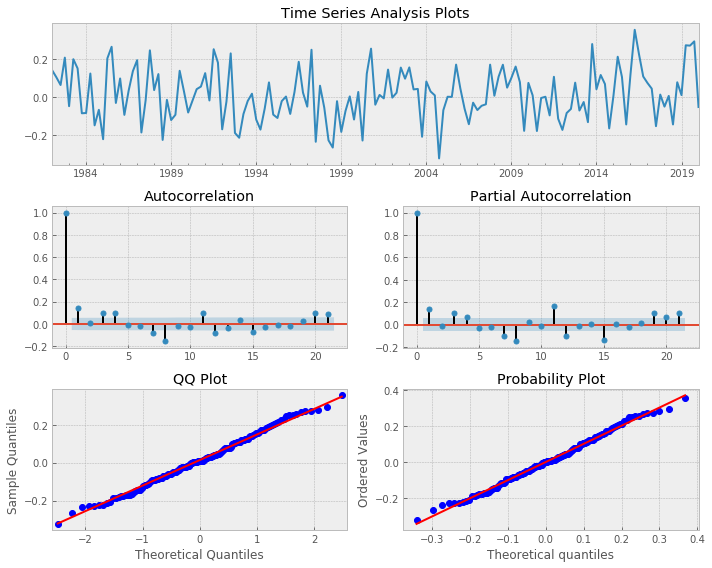

In [146]:
testing.ts_plot(macro_and_assets['Gold & Bond'],lags=21)

In [147]:
reg1_df5 = combined_dummy.copy()

# creating lag 1 for returns
reg1_df5['eq_qrt_ret'] = reg1_df5['eq_qrt_ret'].shift(1)
reg1_df5['bond_qrt_ret'] = reg1_df5['bond_qrt_ret'].shift(1)
reg1_df5['gold_qrt_ret'] = reg1_df5['gold_qrt_ret'].shift(1)
reg1_df5['forex_qrt_ret'] = reg1_df5['forex_qrt_ret'].shift(1)


# creating lag 2 for correlation combinations
reg1_df5['Gold & Bond_lag'] = reg1_df5['Gold & Bond'].shift(1)
reg1_df5['Bond & SP500'] = reg1_df5['Bond & SP500'].shift(1)
reg1_df5['Forex & SP500'] = reg1_df5['Forex & SP500'].shift(1)
reg1_df5['Gold & SP500'] = reg1_df5['Gold & SP500'].shift(1)
reg1_df5['Forex & Bond'] = reg1_df5['Forex & Bond'].shift(1)
reg1_df5['Gold & Forex'] = reg1_df5['Gold & Forex'].shift(1)


reg1_df5 = reg1_df5.dropna()
reg1_df5['constant'] = 1

Y = reg1_df5['Gold & Bond'].values
X = reg1_df5[['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret',
       'Bond & SP500', 'Forex & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Forex', 'Gold & Bond_lag',
              '+GDP+Infl-Unemp','+GDP+Infl+Unemp','constant']]
import statsmodels.api as sm
model = sm.OLS(Y, X)
results = model.fit()
reg1_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.149
Date:                Tue, 21 Jul 2020   Prob (F-statistic):              0.326
Time:                        08:44:09   Log-Likelihood:                 95.006
No. Observations:                 151   AIC:                            -164.0
Df Residuals:                     138   BIC:                            -124.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
eq_qrt_ret         -0.0334      0.154     -0.217      0.829      -0.338       0.271
bond_qrt_ret        0.7284      1.367      0.533      0.595      -1.975       3.432
gold_qrt_ret        0.3082      0.174      1.776      0.078      -0.035       0.651
forex_qrt_ret       0.1226      0.275      0.446      0.657      -0.421       0.667
Bond & SP500       -0.0431      0.067     -0.639      0.524      -0.176       0.090
Forex & SP500      -0.0358      0.047     -0.754      0.452      -0.130       0.058
Gold & SP500       -0.1528      0.074     -2.076      0.040      -0.298      -0.007
Forex & Bond       -0.0391      0.072     -0.540      0.590      -0.182       0.104
Gold & Forex       -0.0532      0.052     -1.018      0.310      -0.157       0.050
Gold & Bond_lag     0.0537      0.091      0.591      0.555      -0.126       0.233
+GDP+Infl-Unemp     0.0232      0.038      0.615      0.540      -0.051       0.098
+GDP+Infl+Unemp     0.0279      0.039      0.706      0.481      -0.050       0.106
constant           -0.0414      0.039     -1.051      0.295      -0.119       0.036
==============================================================================
Omnibus:                        0.479   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.617
Skew:                           0.029   Prob(JB):                        0.735
Kurtosis:                       2.692   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
fig = px.scatter(x=reg1_fittedvalues, y=Y)
fig.show()

In [149]:
Y = reg1_df5['Gold & Bond'].values
X = reg1_df5[['gold_qrt_ret', 'Gold & SP500', 'constant']]
model = sm.OLS(Y, X)
results = model.fit()
reg2_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     4.634
Date:                Tue, 21 Jul 2020   Prob (F-statistic):             0.0112
Time:                        08:44:10   Log-Likelihood:                 92.403
No. Observations:                 151   AIC:                            -178.8
Df Residuals:                     148   BIC:                            -169.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
gold_qrt_ret     0.3158      0.153      2.070      0.040       0.014       0.617
Gold & SP500    -0.1251      0.059     -2.118      0.036      -0.242      -0.008
constant         0.0043      0.011      0.384      0.701      -0.018       0.026
==============================================================================
Omnibus:                        1.779   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.411   Jarque-Bera (JB):                1.492
Skew:                           0.083   Prob(JB):                        0.474
Kurtosis:                       2.542   Cond. No.                         14.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
fig = px.scatter(x=reg2_fittedvalues,y=Y)
fig.show()

In [151]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = sm.OLS(y_train, x_train)
results = model.fit()

fig = px.scatter(x=results.fittedvalues,y=y_train)
fig.show()

In [152]:
y_hat = results.predict(x_test)

fig = px.scatter(x=y_hat,y=y_test)
fig.show()

### 7.6 Gold and Forex

ADF Statistic: -2.733376
p-value: 0.068439
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577

We fail to reject the Null Hypothesis (H0) -- the time series has a unit root and is not stationary


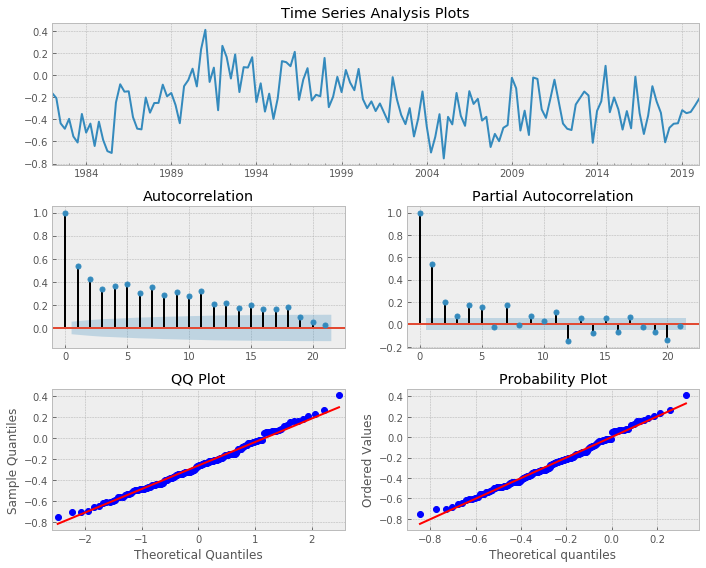

In [153]:
testing.ts_plot(macro_and_assets['Gold & Forex'],lags=21)

In [154]:
reg1_df6 = combined_dummy.copy()

# creating lag 1 for returns
reg1_df6['eq_qrt_ret'] = reg1_df6['eq_qrt_ret'].shift(1)
reg1_df6['bond_qrt_ret'] = reg1_df6['bond_qrt_ret'].shift(1)
reg1_df6['gold_qrt_ret'] = reg1_df6['gold_qrt_ret'].shift(1)
reg1_df6['forex_qrt_ret'] = reg1_df6['forex_qrt_ret'].shift(1)


# creating lag 2 for correlation combinations
reg1_df6['Gold & Forex_lag'] = reg1_df6['Gold & Forex'].shift(2)
reg1_df6['Bond & SP500'] = reg1_df6['Bond & SP500'].shift(2)
reg1_df6['Forex & SP500'] = reg1_df6['Forex & SP500'].shift(2)
reg1_df6['Gold & SP500'] = reg1_df6['Gold & SP500'].shift(2)
reg1_df6['Forex & Bond'] = reg1_df6['Forex & Bond'].shift(2)
reg1_df6['Gold & Bond'] = reg1_df6['Gold & Bond'].shift(2)


reg1_df6 = reg1_df6.dropna()
reg1_df6['constant'] = 1

Y = reg1_df6['Gold & Forex'].values
X = reg1_df6[['eq_qrt_ret', 'bond_qrt_ret', 'gold_qrt_ret', 'forex_qrt_ret',
       'Bond & SP500', 'Forex & SP500', 'Gold & SP500', 'Forex & Bond', 'Gold & Bond', 'Gold & Forex_lag',
              '+GDP+Infl-Unemp','+GDP+Infl+Unemp','constant']]
import statsmodels.api as sm
model = sm.OLS(Y, X)
results = model.fit()
reg1_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     3.150
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           0.000545
Time:                        08:44:12   Log-Likelihood:                 29.244
No. Observations:                 151   AIC:                            -32.49
Df Residuals:                     138   BIC:                             6.737
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
eq_qrt_ret          -0.1812      0.230     -0.786      0.433      -0.637       0.274
bond_qrt_ret        -0.5190      2.112     -0.246      0.806      -4.694       3.656
gold_qrt_ret        -0.1716      0.271     -0.633      0.528      -0.707       0.364
forex_qrt_ret        0.0973      0.419      0.232      0.817      -0.731       0.926
Bond & SP500         0.0346      0.098      0.353      0.724      -0.159       0.228
Forex & SP500        0.1263      0.074      1.712      0.089      -0.020       0.272
Gold & SP500         0.1435      0.110      1.308      0.193      -0.073       0.360
Forex & Bond        -0.0172      0.112     -0.153      0.878      -0.239       0.204
Gold & Bond          0.1195      0.141      0.847      0.398      -0.159       0.398
Gold & Forex_lag     0.4571      0.080      5.715      0.000       0.299       0.615
+GDP+Infl-Unemp      0.0020      0.059      0.035      0.973      -0.114       0.118
+GDP+Infl+Unemp      0.0127      0.061      0.209      0.835      -0.108       0.133
constant            -0.1350      0.061     -2.220      0.028      -0.255      -0.015
==============================================================================
Omnibus:                        3.908   Durbin-Watson:                   1.370
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.763
Skew:                           0.332   Prob(JB):                        0.152
Kurtosis:                       2.604   Cond. No.                         154.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
fig = px.scatter(x=reg1_fittedvalues,y=Y)
fig.show()

In [156]:
Y = reg1_df6['Gold & Forex'].values
X = reg1_df6[[ 'Forex & SP500', 'Gold & Forex_lag','constant']]
model = sm.OLS(Y, X)
results = model.fit()
reg2_fittedvalues = results.fittedvalues
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     18.00
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           1.00e-07
Time:                        08:44:12   Log-Likelihood:                 27.408
No. Observations:                 151   AIC:                            -48.82
Df Residuals:                     148   BIC:                            -39.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Forex & SP500        0.0917      0.061      1.503      0.135      -0.029       0.212
Gold & Forex_lag     0.4250      0.074      5.767      0.000       0.279       0.571
constant            -0.1511      0.025     -5.963      0.000      -0.201      -0.101
==============================================================================
Omnibus:                        2.579   Durbin-Watson:                   1.375
Prob(Omnibus):                  0.275   Jarque-Bera (JB):                2.616
Skew:                           0.286   Prob(JB):                        0.270
Kurtosis:                       2.703   Cond. No.                         4.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [157]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)
model = sm.OLS(y_train, x_train)
results = model.fit()

fig = px.scatter(x=results.fittedvalues,y=y_train)
fig.show()

In [158]:
y_hat = results.predict(x_test)

fig = px.scatter(x=y_hat,y=y_test)
fig.show()

## 8. Clustering

In [159]:
clu = KMeans(n_clusters =3)
clu.fit(combined_dummy.dropna())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [160]:
df3 = combined_dummy.dropna().copy()
df3['cluster'] = clu.labels_
df3.groupby('cluster').mean()

,eq_qrt_ret,bond_qrt_ret,gold_qrt_ret,forex_qrt_ret,Bond & SP500,Forex & SP500,Gold & SP500,Forex & Bond,Gold & Bond,Gold & Forex,+GDP+Infl-Unemp,+GDP+Infl+Unemp
cluster,,,,,,,,,,,,
0,-0.004355,0.006963,0.002274,0.004341,-0.026114,-0.061394,0.005891,-0.072085,0.014226,-0.284011,0,0
1,0.030398,0.011763,0.019303,-0.004564,-0.006219,-0.014905,-0.008326,-0.092813,0.024049,-0.251799,0,1
2,0.026042,0.009384,0.011702,0.001882,0.008727,0.047993,-0.048290,-0.039214,0.006293,-0.259847,1,0


In [161]:
# heatmap of individual features
# run a PCA and then clustering
# what is the best number of clusters

## Next steps:

<ol>
<li> Replicate the analysis with covariance </li>
<li> Complete the analysis for other asset combinations </li>